In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.signal import convolve2d
from scipy.io import loadmat
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('./fer2013.csv')

In [3]:
df_training = df[df.Usage == 'Training']
df_public_testing = df[df.Usage == 'PublicTest']
df_private_testing = df[df.Usage == 'PrivateTest']

In [4]:
X = []

for i in range(len(df)):
    l = df.pixels[i]
    ls = l.split()

    for i in range(len(ls)):
        ls[i] = float(ls[i])
    x = np.reshape(ls, (48, 48))
    X.append(x)

In [5]:
X = np.asarray(X)

In [6]:
X.shape

(35887, 48, 48)

In [7]:
Xtrain = X[ : df_training.shape[0]]
Xpublic_test = X[df_training.shape[0]:df_training.shape[0] + df_public_testing.shape[0]]
Xprivate_test = X[df_training.shape[0] + df_public_testing.shape[0]: ]

In [8]:
Xtrain.shape

(28709, 48, 48)

In [10]:
Y = df.emotion.values

In [11]:
Ytrain = Y[ : df_training.shape[0]] 
Ypublic_test = Y[df_training.shape[0]:df_training.shape[0] + df_public_testing.shape[0]] 
Yprivate_test = Y[df_training.shape[0] + df_public_testing.shape[0]: ] 

In [12]:
Ytrain = Ytrain.astype(int)
Ypublic_test = Ypublic_test.astype(int)
Yprivate_test = Yprivate_test.astype(int)

In [13]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [14]:
def emotion_indicator(number):
    return label_map[number]

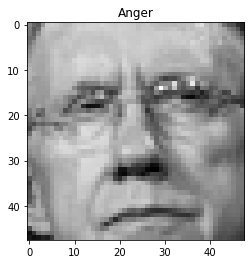

In [15]:
k = 123

plt.imshow(Xtrain[k], cmap = 'gray')
plt.title(emotion_indicator(Ytrain[k]))
plt.show()

In [16]:
def reshape(data):
    l = []

    for i in range(len(data)):
        l.append([data[i]])

    data = np.asarray(l)
    return (data/255.0).astype(np.float32)

In [17]:
Xtrain = reshape(Xtrain)
Xpublic_test = reshape(Xpublic_test)
Xprivate_test = reshape(Xprivate_test)

In [18]:
Xtrain.shape

(28709, 1, 48, 48)

In [19]:
Xpublic_test.shape

(3589, 1, 48, 48)

In [20]:
def rearrange(X):
    # input is (32, 32, 3, N)
    # output is (N, 32, 32, 3)
    # N = X.shape[-1]
    # out = np.zeros((N, 32, 32, 3), dtype=np.float32)
    # for i in xrange(N):
    #     for j in xrange(3):
    #         out[i, :, :, j] = X[:, :, j, i]
    # return out / 255
    return X.transpose(0, 2, 3, 1) 

In [21]:
Xtrain = rearrange(Xtrain)
Xpublic_test =rearrange(Xpublic_test)
Xprivate_test = rearrange(Xprivate_test)

In [22]:
Xtrain.shape

(28709, 48, 48, 1)

In [23]:
Xpublic_test.shape

(3589, 48, 48, 1)

In [24]:
# gradient descent params
max_iter = 12
print_period = 30
N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

In [25]:
# initial weights and same padding for this model
M = 500
K = 7
poolsz = (2, 2)

In [26]:
def init_filter(shape, poolsz):
    # w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2]) / np.prod(poolsz))
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
    return w.astype(np.float32)

In [27]:
W1_shape = (5, 5, Xtrain.shape[3], 20) # (filter_width, filter_height, num_color_channels, num_feature_maps)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

In [28]:
W2_shape = (5, 5, W1_shape[3], 50) # (filter_width, filter_height, old_num_feature_maps, num_feature_maps)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

In [29]:
#same padding

ac1 = Xtrain.shape[1]
ap1 = ac1 / poolsz[0]
ac2 = ap1 
ap2 = ac2 / poolsz[0]
ap2 = int(ap2)
print(ap2)

12


In [33]:
# vanilla ANN weights
W3_init = np.random.randn(W2_shape[-1]*ap2*ap2, M) / np.sqrt(W2_shape[-1]*ap2*ap2 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

In [35]:
# define variables and expressions
# using None as the first shape element takes up too much RAM unfortunately
X = tf.placeholder(tf.float32, shape=(batch_sz, Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3]), name='X')
T = tf.placeholder(tf.int32, shape=(batch_sz,), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
def convpool(X, W, b):
    # just assume pool size is (2,2) because we need to augment it with 1s
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

#conv2d
#strides: A list of ints. 1-D tensor of length 4. The stride of the sliding window for each dimension of input.
#The dimension order is determined by the value of data_format, see below for details.
#Must have strides[0] = strides[3] = 1. For the most common case of the same horizontal and vertices strides, 
# strides = [1, stride, stride, 1]

#max_pool
#ksize: A list or tuple of 4 ints. The size of the window for each dimension of the input tensor.
#strides: A list or tuple of 4 ints. The stride of the sliding window for each dimension of the input tensor.

In [ ]:
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Yish = tf.matmul(Z3, W4) + b4

In [ ]:
cost = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=Yish,
            labels=T
        )
    )

In [ ]:
train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

In [ ]:
# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

In [ ]:
def error_rate(p, t):
    return np.mean(p != t)

In [ ]:
t0 = datetime.now()
LL = []
W1_val = None
W2_val = None
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz),]

            if len(Xbatch) == batch_sz:
                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    # due to RAM limitations we need to have a fixed size input
                    # so as a result, we have this ugly total cost and prediction computation
                    test_cost = 0
                    prediction = np.zeros(len(Xpublic_test))
                    for k in range(len(Xpublic_test) // batch_sz):
                        Xtestbatch = Xpublic_test[k*batch_sz:(k*batch_sz + batch_sz),]
                        Ytestbatch = Ypublic_test[k*batch_sz:(k*batch_sz + batch_sz),]
                        test_cost += session.run(cost, feed_dict={X: Xtestbatch, T: Ytestbatch})
                        prediction[k*batch_sz:(k*batch_sz + batch_sz)] = session.run(
                            predict_op, feed_dict={X: Xtestbatch})
                    err = error_rate(prediction, Ypublic_test)
                    print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    LL.append(test_cost)

    W1_val = W1.eval()
    W2_val = W2.eval()
print("Elapsed time:", (datetime.now() - t0))
plt.plot(LL)
plt.show()

In [1]:
range(500)

range(0, 500)

In [2]:
type(range(500))

range